In [1]:
import pandas as pd
from seaborn import heatmap

from actors import Ship, Geopoint, VesselCategory, Geopoint

grid = pd.read_excel(r"data\velocity.xlsx")
routes = pd.read_excel(r"data\routes.xlsx")
vessels = pd.read_excel(r"data\vessels.xlsx")

In [2]:
from typing import List
from dataclasses import dataclass
from numpy.typing import NDArray

from actors import detect_point_category, speed_limitations, Vessel
from geopy.distance import great_circle


@dataclass
class DijkstraOnGrid:
    weighted_map: NDArray
    actions_list: List[tuple]

    lat: NDArray
    lon: NDArray

    def __post_init__(self):
        x_shape, y_shape = self.weighted_map.shape
        self._field_range_x = set(range(0, x_shape))
        self._field_range_y = set(range(0, y_shape))

        self._empty_grid_generator = lambda: [[None for _ in range(y_shape)] for _ in range(x_shape)]

    def get_route_map(self, vessel: Vessel, init_time: float = 0.0):
        x, y = vessel.location_point.latitude, vessel.location_point.longitude
        assert x in self._field_range_x and y in self._field_range_y

        field = self._empty_grid_generator()
        trace = self._empty_grid_generator()

        queue: list = []
        examined: set = set()

        field[x][y] = init_time
        queue.append((x, y))

        while queue:
            current_cords = queue.pop(0)
            if current_cords in examined:
                continue
            current_time_weigh = field[current_cords[0]][current_cords[1]]
            examined.add(current_cords)
            for shift in self.actions_list:
                cords = (current_cords[0] + shift[0], current_cords[1] + shift[1])
                if cords[0] not in self._field_range_x or cords[1] not in self._field_range_y:
                    continue
                if cords not in examined:
                    weigh = self.weighted_map[cords[0]][cords[1]]
                    speed = speed_limitations[detect_point_category(weigh)](vessel)
                    if speed:
                        queue.append(cords)
                        geo_cords = self.lat[cords], self.lon[cords]
                        geo_curr_cords = self.lat[current_cords], self.lon[current_cords]
                        time_weigh = great_circle(geo_cords, geo_curr_cords).km * 0.539957 / speed
                        if field[cords[0]][cords[1]] is None or field[cords[0]][cords[1]] > current_time_weigh + time_weigh:
                            field[cords[0]][cords[1]] = current_time_weigh + time_weigh
                            trace[cords[0]][cords[1]] = current_cords
        return field, trace

    @staticmethod
    def get_trace_cords(vessel: Vessel, trace_map: List[List[float]]):
        geo_point = (vessel.route_request.latitude, vessel.route_request.longitude)
        trace = [geo_point]
        while geo_point is not None:
            trace.append(trace_map[geo_point[0]][geo_point[1]])
            geo_point = trace_map[geo_point[0]][geo_point[1]]
        return trace
        
    @staticmethod
    def get_trace_time(vessel: Vessel, route_weights: List[List[float]]):
        geo_point = (vessel.route_request.latitude, vessel.route_request.longitude)
        return route_weights[geo_point[0]][geo_point[1]]

    def get_geo(self, vessel: Vessel):
        def to_geo(x_idx, y_idx):
            return Geopoint(
                self.lat[(x_idx, y_idx)],
                self.lon[(x_idx, y_idx)],
            )
        return {
            'start' : to_geo(vessel.location_point.latitude, vessel.location_point.longitude),
            'end': to_geo(vessel.route_request.latitude, vessel.route_request.longitude)
        }

In [4]:
integr_velocity = pd.read_excel('data/IntegrVelocity.xlsx', sheet_name=None)
lat, lon = integr_velocity['lat'], integr_velocity['lon']

In [5]:
from actors import Vessel, speed_limitations

lat, lon = integr_velocity['lat'], integr_velocity['lon']

def to_geo(x_idx, y_idx):
    return Geopoint(
        lat.iloc[(x_idx, y_idx)],
        lon.iloc[(x_idx, y_idx)],
    )

ship1 = Vessel(
    name='ship_1',
    category=VesselCategory.arc8,
    location_point=Geopoint(33, 24),
    route_request=Geopoint(77, 40),
    status=1,
    max_speed=22,
    avg_speed=0.,
    curr_speed=0.,
)

ship2 = Vessel(
    name='ship_2',
    category=VesselCategory.arc5,
    location_point=Geopoint(200, 55),
    route_request=Geopoint(140, 76),
    status=1,
    max_speed=16,
    avg_speed=0.,
    curr_speed=0.,
)

ice_breaker1 = Vessel(
    name='ice_breaker_1',
    category=VesselCategory.arc91,
    location_point=Geopoint(77, 40),
    route_request=None,
    status=1,
    max_speed=18,
    avg_speed=0.,
    curr_speed=0.,
)

ice_breaker2 = Vessel(
    name='ice_breaker_2',
    category=VesselCategory.arc92,
    location_point=Geopoint(143, 50),
    route_request=None,
    status=1,
    max_speed=22,
    avg_speed=0.,
    curr_speed=0.,
)

In [6]:
ACTIONS = [(-1, 0), (1, 0), (0, 1), (0, -1)]
djk = DijkstraOnGrid(
    weighted_map=integr_velocity['03-Mar-2020'].values,
    actions_list=ACTIONS,
    lat=integr_velocity['lat'].values,
    lon=integr_velocity['lon'].values,
)

In [7]:
mapped_routes = {
    ss.name : djk.get_route_map(ss)
    for ss in [ship1, ship2, ice_breaker1, ice_breaker2]    
}

<Axes: >

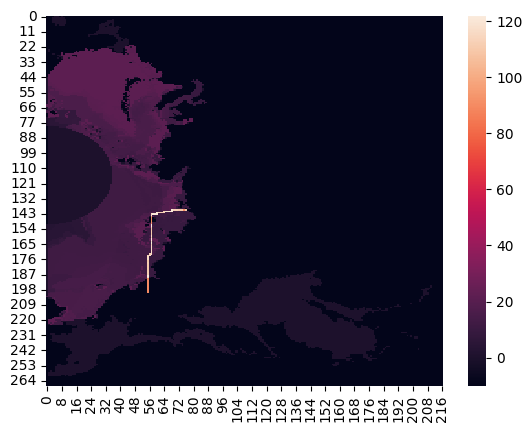

In [8]:
mapp = integr_velocity['03-Mar-2020'].values.copy()
for cords in djk.get_trace_cords(ship2, mapped_routes[ship2.name][1]):
    if cords:
        mapp[cords] += 100
heatmap(mapp)

In [32]:
def get_times_ice_breaker(ship: Ship, ice_breakers: list[Vessel], mapped_routes: dict):
    def create_local_ice_breaker(vessel_category, location_point, route_request, max_speed):
        return Vessel(
            name='local_breaker',
            category=vessel_category,
            location_point=location_point,
            route_request=route_request,
            max_speed=max_speed,
            status=1,
            avg_speed=0.,
            curr_speed=0.,
        )
    time_path_to_ship = {ship.name: {}}
    for ice_breaker in ice_breakers:
        local_ice_breaker = create_local_ice_breaker(
            ice_breaker.category,
            ice_breaker.location_point,
            ship.location_point,
            ice_breaker.max_speed
        )
        grid_time, _ = mapped_routes[ice_breaker.name]
        time_path_to_ship[ship.name][ice_breaker.name] = djk.get_trace_time(local_ice_breaker, grid_time)

    return time_path_to_ship

def get_caravan_routes(ship: Ship, ice_breakers: list[Vessel]):
    def create_local_ice_breaker(vessel_category, location_point, route_request, max_speed):
        return Vessel(
            name='local_breaker',
            category=vessel_category,
            location_point=location_point,
            route_request=route_request,
            max_speed=max_speed,
            status=1,
            avg_speed=0.,
            curr_speed=0.,
        )
    time_path_to_ship = {ship.name: {}}
    for ice_breaker in ice_breakers:
        local_ice_breaker = create_local_ice_breaker(
            ice_breaker.category,
            ship.location_point,
            ship.route_request,
            ship.max_speed
        )
        grid_time, trace_map = djk.get_route_map(ice_breaker)
        time_path_to_ship[ship.name][ice_breaker.name] = {
            'total_time': djk.get_trace_time(local_ice_breaker, grid_time),
            'geo_route': djk.get_trace_cords(local_ice_breaker, trace_map),
        }
    return time_path_to_ship

In [10]:
get_times_ice_breaker(ship2, [ice_breaker1, ice_breaker2], mapped_routes)

{'ship_2': {'ice_breaker_1': 120.66907607720216,
  'ice_breaker_2': 52.64328178208445}}

In [38]:
trace_time_ships = {
    ship.name: djk.get_trace_time(ship, mapped_routes[ship.name][0])
    for ship in [ship1, ship2]
}

In [42]:
sorted(trace_time_ships, key=lambda i: trace_time_ships[i] if trace_time_ships[i] else float('+inf'), reverse=True)

['ship_2', 'ship_1']

In [43]:
from collections import OrderedDict
# приоритетная очередь корабей, 
def make_ships_priority_queue(tts: dict):
    sorted_keys = sorted(tts, key=lambda i: tts[i] if tts[i] else float('+inf'), reverse=True)
    return OrderedDict({
        sort_key: tts[sort_key]
        for sort_key in sorted_keys
    })

In [44]:
make_ships_priority_queue(trace_time_ships)

OrderedDict([('ship_2', 98.91995934507567), ('ship_1', 38.0427812018898)])

In [11]:
djk.get_trace_time(ship2, mapped_routes[ship2.name][0])

98.91995934507567

In [33]:
caravan_routes = get_caravan_routes(ship2, [ice_breaker1, ice_breaker2])

In [36]:
print(
    caravan_routes[ship2.name][ice_breaker1.name]['total_time'],
    caravan_routes[ship2.name][ice_breaker2.name]['total_time'],
)

78.68898420334024 75.97307062393143


In [47]:
def ids2geopoints(route: list[tuple]):
    route = route[:-1]
    if len(route) != 0:
        return list(map(lambda ids: to_geo(*ids), route))

In [48]:
ids2geopoints(caravan_routes[ship2.name][ice_breaker1.name]['geo_route'])

[Geopoint(latitude=72.1578, longitude=128),
 Geopoint(latitude=72.3661, longitude=128),
 Geopoint(latitude=72.5743, longitude=128),
 Geopoint(latitude=72.7823, longitude=128),
 Geopoint(latitude=72.9902, longitude=129),
 Geopoint(latitude=73.1978, longitude=129),
 Geopoint(latitude=73.4053, longitude=129),
 Geopoint(latitude=73.6125, longitude=129),
 Geopoint(latitude=73.8194, longitude=130),
 Geopoint(latitude=74.0262, longitude=130),
 Geopoint(latitude=74.2326, longitude=130),
 Geopoint(latitude=74.4387, longitude=131),
 Geopoint(latitude=74.3581, longitude=131),
 Geopoint(latitude=74.5629, longitude=132),
 Geopoint(latitude=74.7672, longitude=132),
 Geopoint(latitude=74.9712, longitude=132),
 Geopoint(latitude=75.1748, longitude=133),
 Geopoint(latitude=75.378, longitude=133),
 Geopoint(latitude=75.5807, longitude=133),
 Geopoint(latitude=75.783, longitude=134),
 Geopoint(latitude=75.691, longitude=134),
 Geopoint(latitude=75.8914, longitude=135),
 Geopoint(latitude=75.7952, longitu